# Стахостический градиентный бустинг со случайным поиском по сетке и кросс-валидацией для временного ряда

**Disclamer:**
Результаты полученные при использовании данного метода не говорят о том, хороший это метод или нет. Они лишь дают информацию о том, насколько данный метод подходит для выбранных входных данных.

In [35]:
import pandas as pd
import numpy as np

# для разбиения на тестовую и тренировочную выборки
from sklearn.model_selection import train_test_split

# библиотеку для графиков
import matplotlib.pyplot as plt

# метрики моделей регрессии
from sklearn.metrics import mean_squared_error , mean_absolute_error # mse , mae

# модель линейной регрессии
from sklearn.linear_model import LinearRegression

# градиентный бустинг с кросс-валидацией в библиотеке catboost
from catboost import CatBoostRegressor, Pool, cv

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# для выгрузки моделей
import joblib




import statsmodels.api as sm

Выгрузим и обработаем данные.
Наши данные представляют из себя количество операций продажи по определенному сценарию.  

In [36]:
sales = pd.read_csv('data_3.csv', index_col=[0])
display(sales.head(5))
sales.info()

,магазин,день,кол-во
0,магазин 3,2019-01-02,1
1,магазин 2,2019-01-02,3
2,магазин 1,2019-01-02,48
3,магазин 3,2019-01-03,3
4,магазин 1,2019-01-03,87


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   магазин  2606 non-null   object
 1   день     2606 non-null   object
 2   кол-во   2606 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 81.4+ KB


Выгрузили и посмотрели типы. Сразу приведем столбец день к дате. И проверим, все ли даты у нас есть в наличие.

In [37]:
sales['день'] = pd.to_datetime(sales['день'], format='%Y-%m-%d')

display(sales.pivot_table(index='день', values='кол-во', columns = 'магазин'))

print(sales.pivot_table(index='день', values='кол-во', columns = 'магазин').isna().sum())

магазин,магазин 1,магазин 2,магазин 3
день,,,
2019-01-02,48.0,3.0,1.0
2019-01-03,87.0,NaN,3.0
2019-01-04,68.0,1.0,4.0
2019-01-05,75.0,9.0,6.0
2019-01-06,70.0,1.0,5.0
...,...,...,...
2021-05-27,77.0,20.0,5.0
2021-05-28,67.0,26.0,10.0
2021-05-29,70.0,18.0,12.0


магазин
магазин 1     0
магазин 2    17
магазин 3    14
dtype: int64


Отлично. мы знаем, что не для всех магазинов у нас есть данные по каждому месяцу. Исправим это недоразумение. Отсутствие данных = отсутствию продаж, поэтому будем менять на ноль. 

In [38]:
sales = sales.pivot_table(index='день', values='кол-во', columns = 'магазин', fill_value=0)

Кроме того, мы точно знаем, что, например 1 января 2020 года ни один магазин не работал, поэтому дата "2020-01-01" будет отсутствовать, а это плохо. Поэтому ресемплируем данные по дням и заполним пропуски тоже нулями

In [39]:
sales = sales.resample('D').asfreq().fillna(0)

display(sales)
print(sales.isna().sum())

магазин,магазин 1,магазин 2,магазин 3
день,,,
2019-01-02,48.0,3.0,1.0
2019-01-03,87.0,0.0,3.0
2019-01-04,68.0,1.0,4.0
2019-01-05,75.0,9.0,6.0
2019-01-06,70.0,1.0,5.0
...,...,...,...
2021-05-27,77.0,20.0,5.0
2021-05-28,67.0,26.0,10.0
2021-05-29,70.0,18.0,12.0


магазин
магазин 1    0
магазин 2    0
магазин 3    0
dtype: int64


Отлично. Теперь наш времянной ряд приведен в нормальное состояние. И бонусом мы узнали, что не только "2020-01-01" магазины были закрыты, но и еще в какой-то день (размер таблицы вырос с 879 строк до 881 строки). Отсутствовали продажи 1 января 2021г и изначально мы специально умолчали об этом, чтобы проверить правильно ли все отработает.

Посмотрим на графики количества продаж для каждого магазина

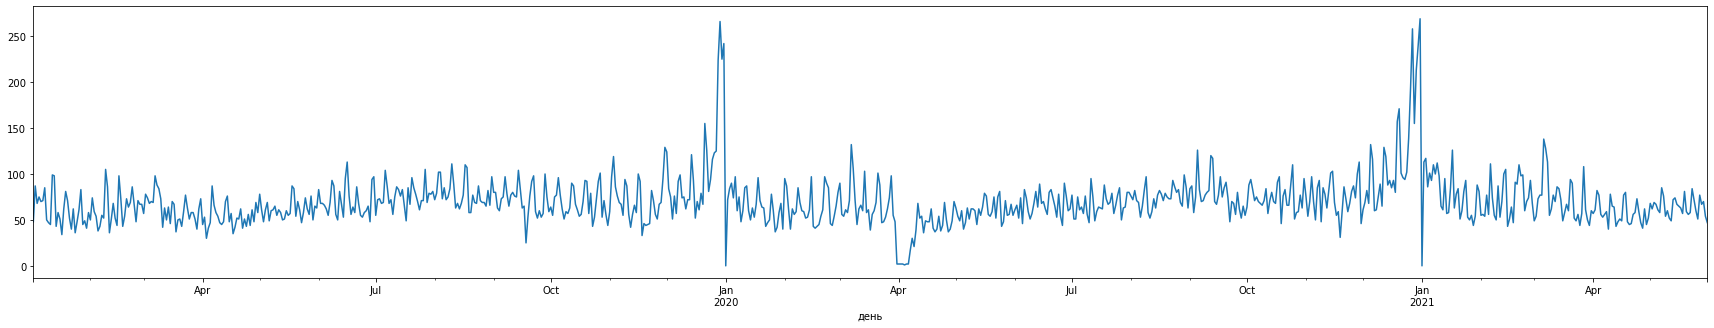

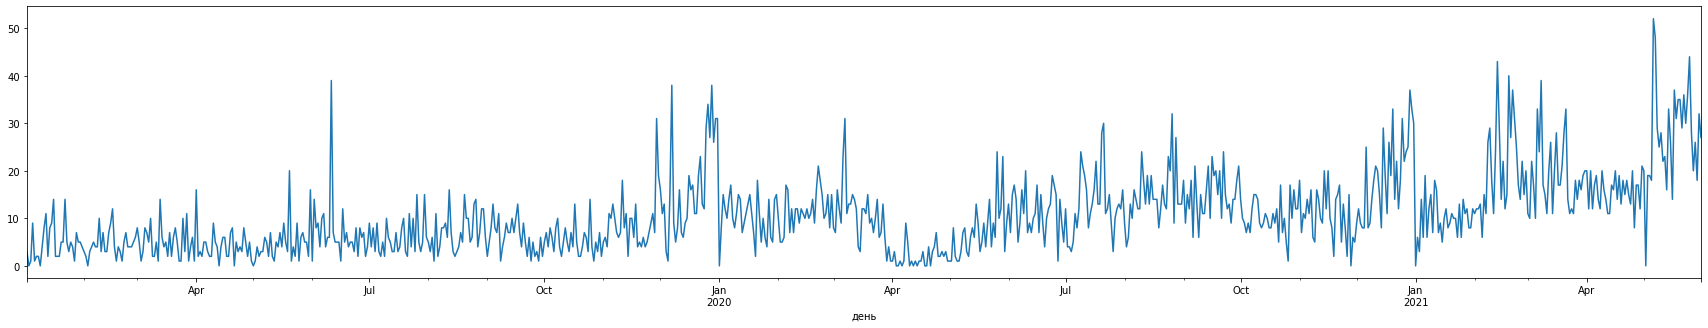

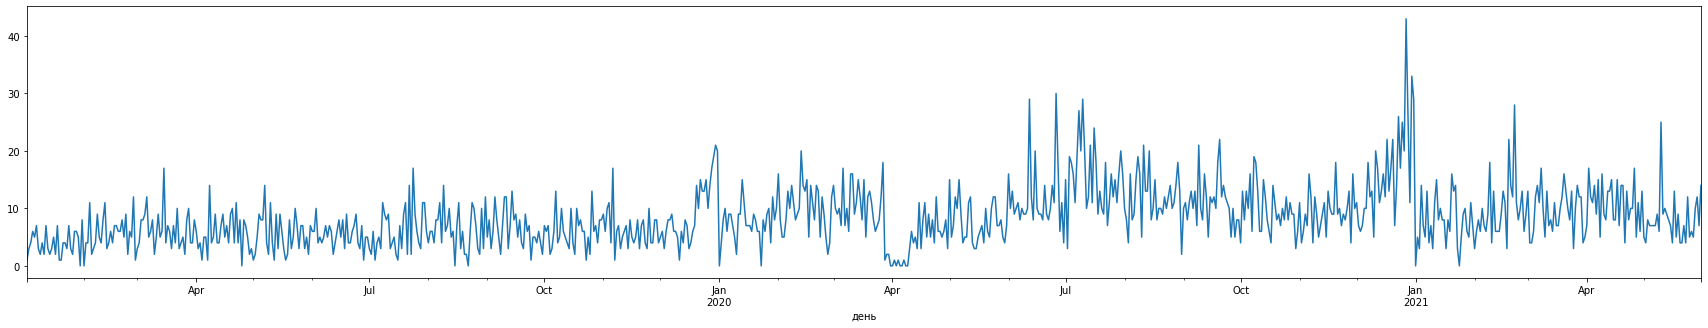

In [40]:
for col in sales.columns:
    sales[col].plot(figsize = (30,5))
    plt.show()

# Кросс-валидированная модель случайного леса  для 1 магазина.

Возьмем данные по 1 магазину и попробуем спрогнозировать количество продаж на будущий месяц. 

Для примера возьмем "магазин 2", потому он выглядит как менее стационарный относительно "магазина 1" и, в отличие от "магазина 3" в конце периода данных явно имеет изменение объемов продаж.



In [41]:
one = sales['магазин 2']

Посмотрим на тренд, сезонность и шумы для нашего тренировочного ряда.

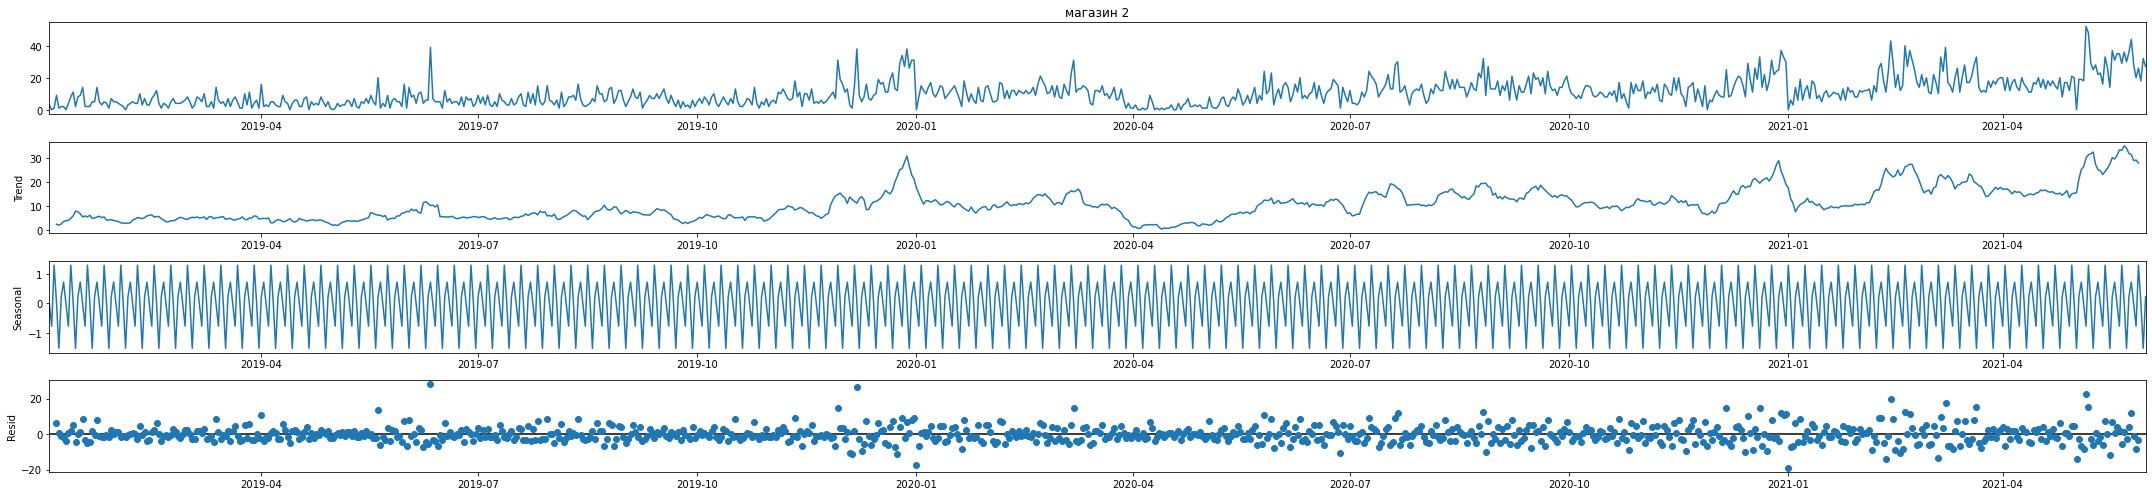

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 7

decomposition = sm.tsa.seasonal_decompose(one, model='additive')

fig = decomposition.plot()
plt.show()

Отлично. В наших данных есть внутригодовая и внутринедельная сезонность, долгосрочный восходящий тренд и увеличение дисперсии шумов со временем. Полный набор...

Из тех данных что у нас есть сгенерируем пачку признаков: год,  месяц, день недели, день месяца, день года, неделю года, скользящее среднее  и отстающие значения.

Но для начала определимся, какая часть выборки пойдет на тренировки и кросс-валидидацию, а какая будет отложена в виде закрытой выборке, на которой будем сравнивать прогноз и фактический результат. Закрытой частью выборки у нас будут продажи за май 2021 года (31 день), а значит, что наши отстающие значения должны начинаться от 31 дня. Возьмем отстающие значения длинной от 31 до 91 дня, а скользящее среднее  - в 31 день

**N.b.:** если выбрать отстающие значения меньше, например в 2 дня, то попадем в ситуацию, когда для прогнозирования количества продаж на 1 мая у нас еще будут признаки (количество продаж 29 и 30 апреля), а для прогнозирования 2 мая у нас будет всего 1 реальный признак и 1 прогнозны (30 апреля и 1 мая). Не говоря уже о том, что 3 мая у нас и вовсе будут 2 прогнозных признака (1 и 2 мая), а строить прогноз на прогнозных данных - значит увеличивать дисперсию и, как следствие, снижать точность итоговых результатов.

In [43]:
def make_features(data, min_lag, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month_of_year'] = data.index.month
    data['day_of_month'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['day_of_year'] = data.index.dayofyear
    data['week_of_year'] = data.index.weekofyear


    for lag in range(min_lag, max_lag + 1):
        data['lag_{}'.format(lag)] = data['sales'].shift(lag)
        
    data['moving_avarage'] = data['sales'].shift().rolling(rolling_mean_size).mean()

    return data

one = one.to_frame().reset_index().rename(columns={'магазин 2':'sales','день':'timestamp'}).set_index('timestamp')

one = make_features(one, min_lag=31, max_lag = 91, rolling_mean_size = 31)
one


<ipython-input-43-4179615ed0cb>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week_of_year'] = data.index.weekofyear


,sales,year,month_of_year,day_of_month,day_of_week,day_of_year,week_of_year,lag_31,lag_32,lag_33,...,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,moving_avarage
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-02,3.0,2019,1,2,2,2,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.0,2019,1,3,3,3,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,1.0,2019,1,4,4,4,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,9.0,2019,1,5,5,5,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-06,1.0,2019,1,6,6,6,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,20.0,2021,5,27,3,147,21,8.0,20.0,13.0,...,10.0,17.0,22.0,10.0,11.0,20.0,15.0,22.0,14.0,26.064516
2021-05-28,26.0,2021,5,28,4,148,21,17.0,8.0,20.0,...,33.0,10.0,17.0,22.0,10.0,11.0,20.0,15.0,22.0,26.451613
2021-05-29,18.0,2021,5,29,5,149,21,17.0,17.0,8.0,...,24.0,33.0,10.0,17.0,22.0,10.0,11.0,20.0,15.0,26.741935


Теперь у нас есть пропуски данных - удалим такие строки. Да, мы потеряем 3 месяца данных, но зато мы знатно расширили набор признаков.

In [44]:
# удалим строки с пропущенными значениями
one.dropna(inplace=True)
one.head(3)

,sales,year,month_of_year,day_of_month,day_of_week,day_of_year,week_of_year,lag_31,lag_32,lag_33,...,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,moving_avarage
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-03,3.0,2019,4,3,2,93,14,1.0,5.0,8.0,...,4.0,0.0,2.0,2.0,1.0,9.0,1.0,0.0,3.0,5.129032
2019-04-04,2.0,2019,4,4,3,94,14,3.0,1.0,5.0,...,8.0,4.0,0.0,2.0,2.0,1.0,9.0,1.0,0.0,5.193548
2019-04-05,5.0,2019,4,5,4,95,14,8.0,3.0,1.0,...,11.0,8.0,4.0,0.0,2.0,2.0,1.0,9.0,1.0,5.161290


Теперь разделим нашу выборку на ту, на которой будем обучать и кросс-валидировать модель и ту, которую будем пытаться спрогнозировать.

In [51]:
one_valid = one.iloc[-31:].copy()

one_train = one.iloc[:-31].copy()

И разделим каждую из частей на признаки и целевые переменные

In [52]:
target_train = one_train.sales
features_train = one_train.drop(columns='sales')

display(target_train.index.min(), target_train.index.max())
display(features_train.index.min(), features_train.index.max())



target_valid = one_valid.sales
features_valid = one_valid.drop(columns='sales')

display(target_valid.index.min(), target_valid.index.max())
display(features_valid.index.min(), features_valid.index.max())


Timestamp('2019-04-03 00:00:00')

Timestamp('2021-04-30 00:00:00')

Timestamp('2019-04-03 00:00:00')

Timestamp('2021-04-30 00:00:00')

Timestamp('2021-05-01 00:00:00')

Timestamp('2021-05-31 00:00:00')

Timestamp('2021-05-01 00:00:00')

Timestamp('2021-05-31 00:00:00')

## Baseline
В качесте baseline будем использовать прогноз методом линейной регресси.

In [76]:
model_linear = LinearRegression()
model_linear.fit(features_train,target_train)

pred= model_linear.predict(features_valid)

print("rmse обучающей выборки:", mean_squared_error(target_valid, pred)**0.5 )
print("mae обучающей выборки:", mean_absolute_error(target_valid, pred) )


rmse обучающей выборки: 13.439540652590095
mae обучающей выборки: 9.944554165320575


Отлично, у нас есть на что ориентироваться.

## Стахостический градиентный бустинг со случайным поиском по сетке и кросс-валидацией

Чтобы было быстрее будем искать параметры а-ля "по теореме Вейштрассе о сходящихся подпоследовательностях". Т.е. сначала будем искать опимум на большом интервале, найдя большой интервал - будем искать оптимум на интервалаз вложенных в этот интервал.

In [78]:
cv_dataset = Pool(data=features_train, label=target_train,
                  cat_features=None)




params = {"loss_function": "RMSE"}

scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot=False,
            as_pandas=True)




model_catboost = CatBoostRegressor()

grid = {'max_depth':range(1,20,4),
        'learning_rate':np.arange(0.0, 1.0, 0.2),
        'iterations':range(1,500,100)
       }

randomized_search_result = model_catboost.randomized_search(grid, 
                                       X=cv_dataset,
                                       cv=5,
                                       plot=False)

0:	learn: 12.7210332	test: 12.6718523	best: 12.6718523 (0)
1:	learn: 12.4736409	test: 12.4309551	best: 12.4309551 (1)
2:	learn: 12.2403564	test: 12.2049569	best: 12.2049569 (2)
3:	learn: 12.0188316	test: 11.9925976	best: 11.9925976 (3)
4:	learn: 11.7831874	test: 11.7594593	best: 11.7594593 (4)
5:	learn: 11.5721855	test: 11.5536253	best: 11.5536253 (5)
6:	learn: 11.3742741	test: 11.3646691	best: 11.3646691 (6)
7:	learn: 11.1740272	test: 11.1680785	best: 11.1680785 (7)
8:	learn: 10.9866729	test: 10.9858965	best: 10.9858965 (8)
9:	learn: 10.8029550	test: 10.8069547	best: 10.8069547 (9)
10:	learn: 10.6264344	test: 10.6342888	best: 10.6342888 (10)
11:	learn: 10.4327034	test: 10.4441645	best: 10.4441645 (11)
12:	learn: 10.2575247	test: 10.2726303	best: 10.2726303 (12)
13:	learn: 10.0981092	test: 10.1215920	best: 10.1215920 (13)
14:	learn: 9.9401075	test: 9.9672863	best: 9.9672863 (14)
15:	learn: 9.7748467	test: 9.8108984	best: 9.8108984 (15)
16:	learn: 9.6317678	test: 9.6759853	best: 9.67598

In [79]:
print('depth:',randomized_search_result['params']['depth'])
print('iterations:',randomized_search_result['params']['iterations'])
print('learning_rate:',randomized_search_result['params']['learning_rate'])

depth: 1
iterations: 401
learning_rate: 0.4


Теперь мы знаем, что глубина от 1 до 5- оптимальна, количество итераций должно быть от 401 до 501 и скорость обучения от 0.2 до 0.6

In [84]:
model_catboost = CatBoostRegressor()

grid = {'max_depth':range(1,5,1),
        'learning_rate':np.arange(0.2, 0.6, 0.01),
        'iterations':range(401,501,1)
       }

randomized_search_result = model_catboost.randomized_search(grid, 
                                       X=cv_dataset,
                                       cv=5,
                                       plot=False)

0:	learn: 10.8864292	test: 10.8033171	best: 10.8033171 (0)	total: 399us	remaining: 197ms
1:	learn: 9.2541234	test: 9.0592788	best: 9.0592788 (1)	total: 734us	remaining: 180ms
2:	learn: 8.1674912	test: 7.8407822	best: 7.8407822 (2)	total: 1.06ms	remaining: 173ms
3:	learn: 7.6078407	test: 7.2323657	best: 7.2323657 (3)	total: 1.39ms	remaining: 170ms
4:	learn: 7.2678653	test: 6.8499798	best: 6.8499798 (4)	total: 1.72ms	remaining: 168ms
5:	learn: 7.0512131	test: 6.6238129	best: 6.6238129 (5)	total: 2.09ms	remaining: 170ms
6:	learn: 6.8388454	test: 6.4048007	best: 6.4048007 (6)	total: 2.42ms	remaining: 168ms
7:	learn: 6.6599932	test: 6.1946152	best: 6.1946152 (7)	total: 2.78ms	remaining: 169ms
8:	learn: 6.5393558	test: 6.1047658	best: 6.1047658 (8)	total: 3.11ms	remaining: 167ms
9:	learn: 6.3969014	test: 5.9145785	best: 5.9145785 (9)	total: 3.43ms	remaining: 166ms
10:	learn: 6.2857036	test: 5.7847349	best: 5.7847349 (10)	total: 3.76ms	remaining: 165ms
11:	learn: 6.2244143	test: 5.6714176	bes

In [85]:
print('depth:',randomized_search_result['params']['depth'])
print('iterations:',randomized_search_result['params']['iterations'])
print('learning_rate:',randomized_search_result['params']['learning_rate'])

depth: 2
iterations: 404
learning_rate: 0.3900000000000002


Теперь обучим модель на найденных параметрах

In [86]:
depth = randomized_search_result['params']['depth']
iterations = randomized_search_result['params']['iterations']
learning_rate = randomized_search_result['params']['learning_rate']
model_boost = CatBoostRegressor(depth=depth, iterations=iterations, learning_rate=learning_rate)
model_boost.fit(features_train,target_train)

0:	learn: 6.7993937	total: 533us	remaining: 215ms
1:	learn: 6.5739735	total: 1.21ms	remaining: 244ms
2:	learn: 6.3069271	total: 1.77ms	remaining: 236ms
3:	learn: 6.0179516	total: 2.33ms	remaining: 234ms
4:	learn: 5.9291243	total: 2.87ms	remaining: 229ms
5:	learn: 5.8267199	total: 3.46ms	remaining: 230ms
6:	learn: 5.7727708	total: 3.99ms	remaining: 227ms
7:	learn: 5.6612982	total: 4.65ms	remaining: 230ms
8:	learn: 5.6312888	total: 5.19ms	remaining: 228ms
9:	learn: 5.5902480	total: 5.74ms	remaining: 226ms
10:	learn: 5.5397219	total: 6.28ms	remaining: 224ms
11:	learn: 5.5235755	total: 6.82ms	remaining: 223ms
12:	learn: 5.4799126	total: 7.38ms	remaining: 222ms
13:	learn: 5.4470689	total: 7.95ms	remaining: 221ms
14:	learn: 5.3984228	total: 8.49ms	remaining: 220ms
15:	learn: 5.3754552	total: 9.04ms	remaining: 219ms
16:	learn: 5.3319521	total: 9.58ms	remaining: 218ms
17:	learn: 5.2792431	total: 10.4ms	remaining: 222ms
18:	learn: 5.2506374	total: 10.8ms	remaining: 220ms
19:	learn: 5.2329733	to

Проверим, правда ли модель лучше чем baseline

In [88]:
pred = model_boost.predict(features_valid)

print("rmse тестовой выборки: ", mean_squared_error(target_valid, pred)**0.5)
print("mae тестовой выборки: ", mean_absolute_error(target_valid, pred))


rmse тестовой выборки:  14.566611997050654
mae тестовой выборки:  11.679131409122974


Мдаааа.. А линейная регрессия то лучше. На всякий случай, посмотрим еще и на график.

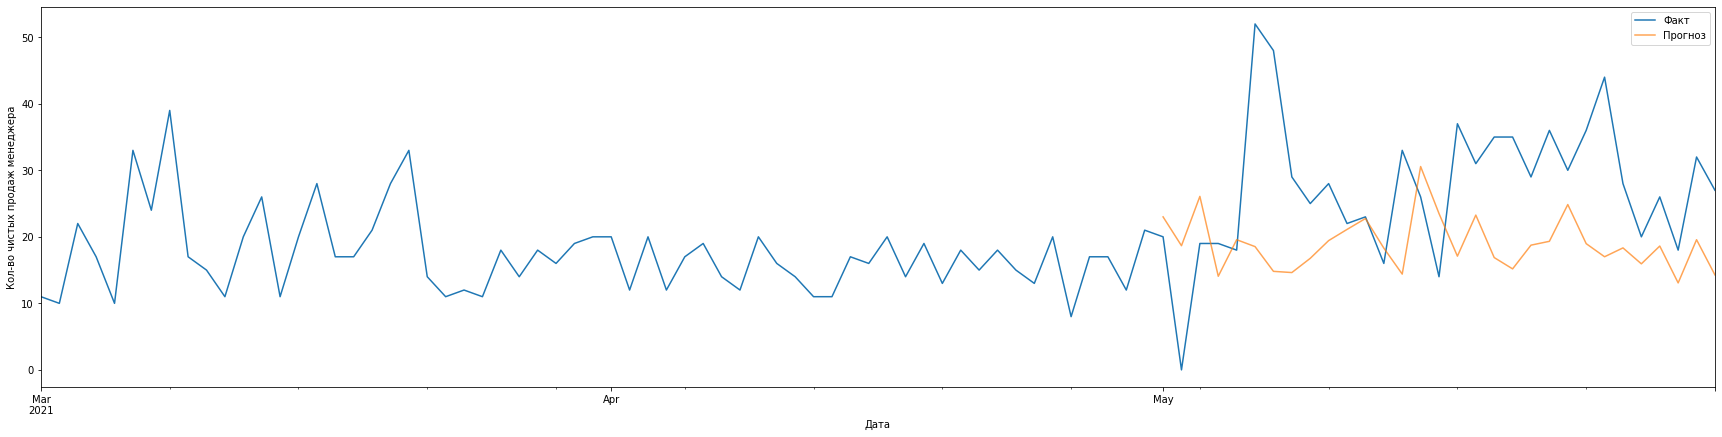

Прогнозная сумма продаж за месяц: 587.3
Фактическая сумма продаж за месяц: 856.0


In [100]:


# возьмем реальные значения выборки, начиная с начала марта 2021 года и отобразим их на графике
ax = one['2021-03-01':].sales.plot(label='Факт')

# отобразим на графике прогнозные значения
pd.DataFrame(pred, columns=['Прогноз'], index=target_valid.index).plot(ax=ax, label='Прогноз', alpha=.7, figsize=(30, 7))

# зададим название осей и включим отображение легенды 
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во чистых продаж менеджера')
plt.legend()
plt.show()

print("Прогнозная сумма продаж за месяц:", round(pred.sum(),2))
print("Фактическая сумма продаж за месяц:",target_valid.sum())